In [ ]:
!pip install transformers datasets evaluate
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.2 MB/s eta 0:00:00


In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 4.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import io
import os
import re
import matplotlib.pyplot as plt### plotting bar chart
import string
import evaluate
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
from transformers import create_optimizer,T5TokenizerFast,DataCollatorForSeq2Seq,TFT5ForConditionalGeneration,TFAutoModelForSeq2SeqLM,AutoModelForSeq2SeqLM,TFT5ForConditionalGeneration

In [ ]:
BATCH_SIZE=64
MAX_LENGTH=128

# Data Preparation

In [ ]:
#dataset_id="liweili/c4_200m"
dataset_id="leslyarun/c4_200m_gec_train100k_test25k"

In [ ]:
dataset = load_dataset(dataset_id)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 25000
    })
})

In [ ]:
dataset['train'][0]

{'input': 'Bitcoin is for $7,094 this morning, which CoinDesk says.',
 'output': 'Bitcoin goes for $7,094 this morning, according to CoinDesk.'}

In [ ]:
model_id="t5-small"
tokenizer=T5TokenizerFast.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):

  inputs = [example for example in examples['input']]
  targets = [example for example in examples['output']]

  model_inputs = tokenizer(inputs, text_target=targets,max_length=MAX_LENGTH, truncation=True)
  return model_inputs

In [ ]:
tokenized_dataset=dataset.map(preprocess_function,batched=True,remove_columns=dataset["train"].column_names)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 25000
    })
})

In [ ]:
tokenized_dataset['train'][1000]

{'input_ids': [6844, 3, 18, 3, 26, 51, 226, 3, 14198, 169, 53, 39, 1339, 5, 1],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [6844, 3, 26, 51, 226, 3, 14198, 3, 18, 150, 1339, 831, 5, 1]}

In [ ]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_id)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,model=model, return_tensors="tf")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
train_dataset=tokenized_dataset["train"].to_tf_dataset(
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
val_dataset=tokenized_dataset["test"].to_tf_dataset(
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

In [ ]:
for i in val_dataset.take(1):
  print(i)

{'input_ids': <tf.Tensor: shape=(64, 98), dtype=int64, numpy=
array([[ 9139,   138,  2253, ...,     0,     0,     0],
       [ 9627,    37,  5791, ...,     0,     0,     0],
       [  116,    27,  4839, ...,     0,     0,     0],
       ...,
       [20255,  3535,     2, ...,     0,     0,     0],
       [10846,   670,    11, ...,     0,     0,     0],
       [ 1541,   132,    19, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(64, 98), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'labels': <tf.Tensor: shape=(64, 99), dtype=int64, numpy=
array([[   37, 13477,  2253, ...,  -100,  -100,  -100],
       [ 9627,    37,  5791, ...,  -100,  -100,  -100],
       [    3,    99,    27, ...,  -100,  -100,  -100],
       ...,
       [20255,  3535,     2, ...,  -100,  -100,  -100],
       [10846,   670

# Modeling

In [ ]:
model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training

In [ ]:
num_epochs = 5
num_train_steps=len(train_dataset)*num_epochs

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
)
model.compile(optimizer=optimizer)

In [ ]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=num_epochs
)

Epoch 1/5
1563/1563 [==============================] - 1803s 1s/step - loss: 0.9211 - val_loss: 0.7682
Epoch 2/5
1563/1563 [==============================] - 1736s 1s/step - loss: 0.8296 - val_loss: 0.7395
Epoch 3/5
1563/1563 [==============================] - 1681s 1s/step - loss: 0.8069 - val_loss: 0.7278
Epoch 4/5
1563/1563 [==============================] - 1730s 1s/step - loss: 0.7938 - val_loss: 0.7214
Epoch 5/5
1563/1563 [==============================] - 1733s 1s/step - loss: 0.7882 - val_loss: 0.7203


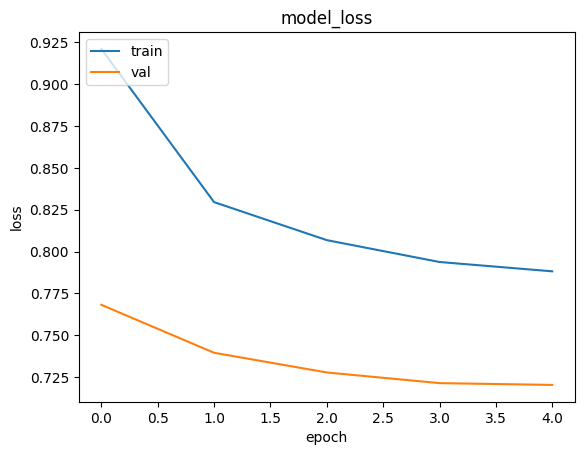

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save_weights('/content/drive/MyDrive/nlp/gec/t5-small.h5')

# Evaluation

In [ ]:
metric = evaluate.load("sacrebleu")

In [ ]:
all_preds = []
all_labels = []

for batch in val_dataset.take(5):
  print(batch)
  predictions = model.generate(
      input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
  )
  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  labels = batch["labels"].numpy()
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  all_preds.extend(decoded_preds)
  all_labels.extend(decoded_labels)

result = metric.compute(predictions=all_preds, references=all_labels)
print(result)

{'input_ids': <tf.Tensor: shape=(64, 98), dtype=int64, numpy=
array([[ 9139,   138,  2253, ...,     0,     0,     0],
       [ 9627,    37,  5791, ...,     0,     0,     0],
       [  116,    27,  4839, ...,     0,     0,     0],
       ...,
       [20255,  3535,     2, ...,     0,     0,     0],
       [10846,   670,    11, ...,     0,     0,     0],
       [ 1541,   132,    19, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(64, 98), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'labels': <tf.Tensor: shape=(64, 99), dtype=int64, numpy=
array([[   37, 13477,  2253, ...,  -100,  -100,  -100],
       [ 9627,    37,  5791, ...,  -100,  -100,  -100],
       [    3,    99,    27, ...,  -100,  -100,  -100],
       ...,
       [20255,  3535,     2, ...,  -100,  -100,  -100],
       [10846,   670

InvalidArgumentError: ignored

In [ ]:
wrong_english=[
    "Dady hav'e eateing her foot",
    "DJ Sorryyouwastedyourmoneytobehere",
    "i used to like to swimming",
    "maybe we should organized a meetin with the people from unesco",
    "when are we goinge to start play football",
    "many a time rain fall in my city",
   ]
tokenized=tokenizer(
  wrong_english,
  padding="longest",
  max_length=MAX_LENGTH,
  truncation=True,
  return_tensors='pt'
)
out=pretrained_model.generate(**tokenized, max_length=128)
print(out)

In [ ]:
all_preds[1:3]

In [ ]:
decoded_preds

In [ ]:
decoded_labels

# Testing


In [ ]:
wrong_english=[
    "Dady hav'e eateing her foot",
    "DJ Sorryyouwastedyourmoneytobehere",
    "i used to like to swimming",
    "maybe we should organized a meetin with the people from unesco",
    "when are we goinge to start play football",
    "many a time rain fall in my city"
    ]
tokenized=tokenizer(
  wrong_english,
  padding="longest",
  max_length=MAX_LENGTH,
  truncation=True,
  return_tensors='tf'
)
out = model.generate(**tokenized, max_length=128)
print(out)

tf.Tensor(
[[    0 12919    63     3 18261    31    15   342    53   160  2418     5
      1     0     0     0     0]
 [    0  6920 11342  4188  9491  1054 13055 28442   235   346    88    60
      5     1     0     0     0]
 [    0     3    23   261    12   114  5989     5     1     0     0     0
      0     0     0     0     0]
 [    0  2087    62   225  7958     3     9  1338    28     8   151    45
      8   245  3523     5     1]
 [    0   116    33    62   352    12   456  1556  3370    58     1     0
      0     0     0     0     0]
 [    0   186   648  3412  1590    16    82   690     5     1     0     0
      0     0     0     0     0]], shape=(6, 17), dtype=int32)


In [ ]:
for i in range(len(wrong_english)):
  print(wrong_english[i]+"------------>"+tokenizer.decode(out[i], skip_special_tokens=True))

Dady hav'e eateing her foot------------>Dady hav'eateing her foot.
DJ Sorryyouwastedyourmoneytobehere------------>DJ Sorryyouwastedyourmoneytobehere.
i used to like to swimming------------>i used to like swimming.
maybe we should organized a meetin with the people from unesco------------>maybe we should organize a meeting with the people from the unesco.
when are we goinge to start play football------------>when are we going to start playing football?
many a time rain fall in my city------------>many times rain fall in my city.


# Testing on Pretrained Model (No FineTuning)

In [ ]:
pretrained_model=AutoModelForSeq2SeqLM.from_pretrained(
    "juancavallotti/t5-base-gec"
)

In [ ]:
wrong_english=[
    "Dady hav'e eateing her foot",
    "DJ Sorryyouwastedyourmoneytobehere",
    "i used to like to swimming",
    "maybe we should organized a meetin with the people from unesco",
    "when are we goinge to start play football",
    "many a time rain fall in my city",
   ]
tokenized=tokenizer(
  wrong_english,
  padding="longest",
  max_length=MAX_LENGTH,
  truncation=True,
  return_tensors='pt'
)
out=pretrained_model.generate(**tokenized, max_length=128)
print(out)

In [ ]:
for i in range(len(wrong_english)):
  print(wrong_english[i]+"------------>"+tokenizer.decode(out[i], skip_special_tokens=True))